# Pendulum dropout attempt

In [1]:
import os
import pandas as pd
import numpy as np
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

np.set_printoptions(precision=6, suppress=True)

In [2]:
base = '../../data/raw'
data_path = 'pendulum/20231006143449281374.csv'
full_path = os.path.join(base, data_path)

raw = pd.read_csv(full_path)

In [3]:
raw.head()

,id,time,qpos,qvel,qacc,ctrl
0,0,0.001,[0.],[0.],[0.],[0.]
1,1,0.002,[1.72930568e-07],[0.00017293],[0.17293057],[0.18849432]
2,2,0.003,[6.91714978e-07],[0.00051878],[0.34585384],[0.3769812]
3,3,0.004,[1.72926192e-06],[0.00103755],[0.51876253],[0.56545319]
4,4,0.005,[3.45845819e-06],[0.0017292],[0.69164933],[0.75390286]


In [4]:
def str_to_list(s: str) -> np.ndarray:
    return np.fromstring(s[1: -1], dtype=float, sep=' ')


def transform_to_numpy(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    x_res = []
    y_res = []

    for _, row in df.iterrows():
        row = row.to_list()[2:]
        x_res.append(np.r_[str_to_list(row[0]), str_to_list(row[1]), str_to_list(row[3])])
        y_res.append(str_to_list(row[2]))

    return np.array(x_res), np.array(y_res)

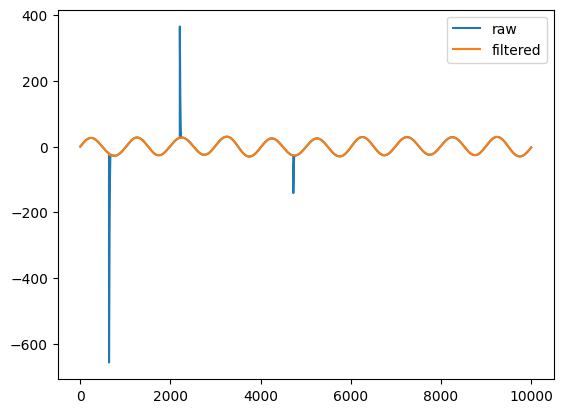

In [5]:
x_data, y_data = transform_to_numpy(raw)

# filter acceleration
qacc = y_data[:, 0]

# apply median filter with window 3
qacc_filtered = np.zeros_like(qacc)

import scipy.signal as signal

# apply median filter
qacc_filtered = signal.medfilt(qacc, 101)

plt.plot(qacc, label="raw")
plt.plot(qacc_filtered, label="filtered")
plt.legend()

# y_data = qacc_filtered.reshape(-1, 1)

In [6]:

proportion = 0.2
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=proportion, random_state=42)

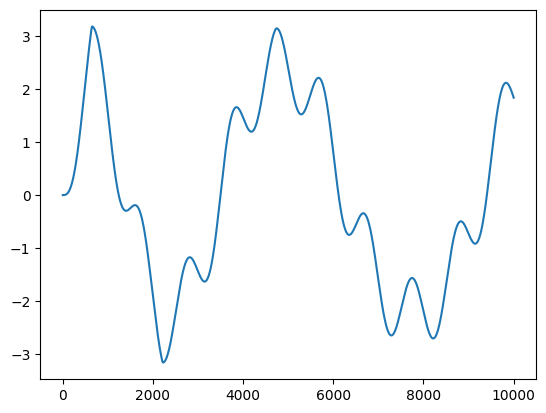

In [7]:
# target position
plt.plot(x_data[:, 0])

In [8]:
train_loader = DataLoader(
    TensorDataset(torch.tensor(x_train), torch.tensor(y_train)),
    batch_size=20,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(x_test), torch.tensor(y_test)),
    batch_size=20,
    shuffle=True
)

In [43]:
class Naive(nn.Module):
    def __init__(
        self, input_dim: int, output_dim: int, dtype: torch.dtype = torch.float64
    ):
        super(Naive, self).__init__()

        self.dropout = nn.Dropout(0.1)

        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),
            self.dropout,
            nn.Sigmoid(),
            self.dropout,
            nn.Linear(100, output_dim),
        ).type(dtype)

    def forward(self, x):
        return self.model(x)

In [44]:
def to_device(_device: torch.device, *tensors: torch.Tensor) -> tuple[torch.Tensor, ...]:
    return tuple(t.to(_device) for t in tensors)


def train_one_epoch(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _train_loader: DataLoader,
        _epoch_num: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    # best score for checkpointing
    _best = np.inf

    # training loop description
    _model.train()
    _train_loss = 0.0
    # iterate over dataset
    for i, data in enumerate(_train_loader, 1):
        _x, _y = to_device(_device, *data)

        # zero the parameter gradients
        _optimizer.zero_grad()

        # forward pass and loss calculation
        _outputs = _model(_x)
        _loss = _loss_fn(_outputs, _y)

        # backward pass
        _loss.backward()

        # optimizer run
        _optimizer.step()

        _train_loss += _loss.item()

    print(f'Epoch {_epoch_num}, Loss: {_train_loss / len(_train_loader)}')


def val_one_epoch(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _val_loader: DataLoader,
        _best: float,
        _epoch_num: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    # validation
    _val_loss = 0.0
    with torch.no_grad():
        _model.eval()  # evaluation mode
        for i, data in enumerate(_val_loader, 1):
            _x, _y = to_device(_device, *data)

            _outputs = _model(_x)
            _val_loss += _loss_fn(_outputs, _y).item()

        print(f'Validation {_epoch_num}, Loss: {_val_loss / len(_val_loader)}')

        if _val_loss / len(_val_loader) > _best:
            torch.save(_model.state_dict(), _ckpt_path)
            _best = _val_loss / len(_val_loader)
    return _best


def train(
        _model: nn.Module,
        _optimizer: torch.optim.Optimizer,
        _loss_fn: torch.nn.Module,
        _train_loader: DataLoader,
        _val_loader: DataLoader,
        _epochs: int,
        _device: torch.device = "cpu",
        _ckpt_path: str = "best.pt",
):
    best = -float('inf')
    for epoch in range(_epochs):
        train_one_epoch(_model, _optimizer, _loss_fn, _train_loader, epoch, _device, _ckpt_path)
        best = val_one_epoch(_model, _optimizer, _loss_fn, _val_loader, best, epoch, _device, _ckpt_path)

In [45]:
device = 'cpu' # 'cuda' if torch.cuda.is_available else 'cpu'
model = Naive(x_data.shape[1], y_data.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
loss_fn = torch.nn.MSELoss()
# writer = SummaryWriter()

In [46]:
train(model, optimizer, loss_fn, train_loader, val_loader, 30, device)

Epoch 0, Loss: 602.3995943087012
Validation 0, Loss: 235.31940116505382
Epoch 1, Loss: 419.19874919896074
Validation 1, Loss: 172.02996156531174
Epoch 2, Loss: 377.3024181466002
Validation 2, Loss: 161.27501478756
Epoch 3, Loss: 365.8646345599081
Validation 3, Loss: 158.3710205077413
Epoch 4, Loss: 361.1137706974407
Validation 4, Loss: 158.5340956720767
Epoch 5, Loss: 360.13327709377614
Validation 5, Loss: 158.30073329744405
Epoch 6, Loss: 358.49919982548715
Validation 6, Loss: 154.31675182306824
Epoch 7, Loss: 357.0022205069418
Validation 7, Loss: 154.12380363617135
Epoch 8, Loss: 355.87794218361597
Validation 8, Loss: 159.5222704520991
Epoch 9, Loss: 353.47685113118894
Validation 9, Loss: 158.96145765478613
Epoch 10, Loss: 354.7419348195524
Validation 10, Loss: 153.09515953050644
Epoch 11, Loss: 354.5735443633457
Validation 11, Loss: 152.23993814496552
Epoch 12, Loss: 354.7842476123096
Validation 12, Loss: 155.27861741428651
Epoch 13, Loss: 352.1256692281628
Validation 13, Loss: 153.

In [47]:
predicted_tensor = model(torch.tensor(x_data).to(device))
predicted_acc: np.ndarray = predicted_tensor.cpu().detach().numpy()

# Simulation

In [48]:
x_data[0]

array([0., 0., 0.])

In [49]:
model(torch.tensor(x_data[0]).to(device))

tensor([0.8233], dtype=torch.float64, grad_fn=<ViewBackward0>)

In [50]:
def euler(q0, dq, ddq, dt):
    q = q0 + dq * dt
    dq = dq + ddq * dt
    return q, dq

def rk4(f, q, dq, ddq, dt):
    """
    Runge-Kutta 4th order

    :param f: function to integrate
    :param q: initial position
    :param dq: initial velocity
    :param ddq: predicted acceleration
    :param dt: time step
    """

    k1 = f(q, dq, ddq)
    k2 = f(q + k1 * dt / 2, dq + k1 * dt / 2, ddq)
    k3 = f(q + k2 * dt / 2, dq + k2 * dt / 2, ddq)
    k4 = f(q + k3 * dt, dq + k3 * dt, ddq)
    q = q + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6
    dq = dq + (k1 + 2 * k2 + 2 * k3 + k4) * dt / 6
    return q, dq



def simulate(q0, dq0, ddq, dts):
    """
    Given an initial state q0, dq0 and predicted ddq, simulate the dynamics

    :param q0: initial position
    :param dq0: initial velocity
    :param ddq: predicted acceleration
    :param time_series: a series of dt
    """

    q = []
    dq = []
    for dt, ddq in zip(dts, ddq):
        q0, dq0 = euler(q0, dq0, ddq, dt)
        q.append(q0)
        dq.append(dq0)
    return np.array(q), np.array(dq)

In [51]:
timestamps = raw["time"]

dts = np.gradient(timestamps)

q0 = x_data[0, 0]
dq0 = x_data[0, 1]

simq, simdq = simulate(q0, dq0, predicted_acc[:, 0], dts)

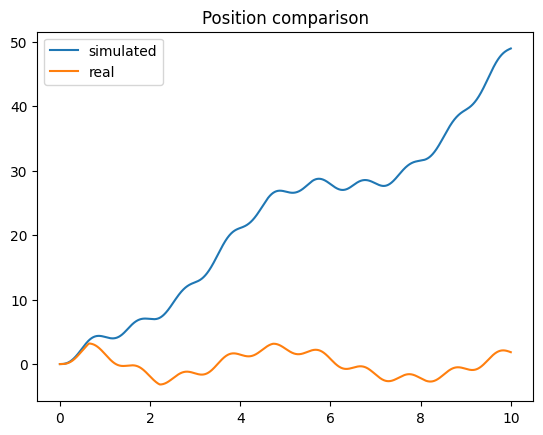

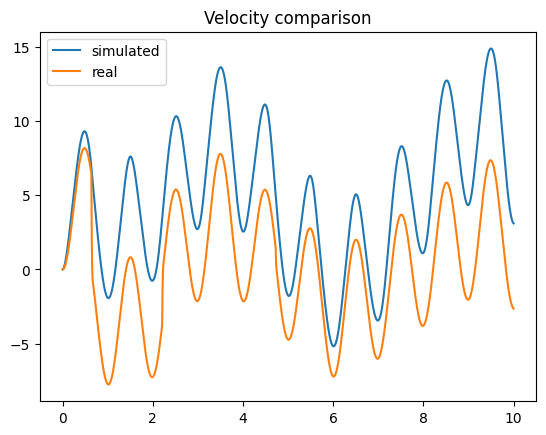

In [52]:
plt.title('Position comparison')
plt.plot(timestamps, simq, label="simulated")
plt.plot(timestamps, x_data[:, 0], label="real")
plt.legend()

plt.figure()
plt.title('Velocity comparison')
plt.plot(timestamps, simdq, label="simulated")
plt.plot(timestamps, x_data[:, 1], label="real")
plt.legend()

/tmp/ipykernel_28139/2097152361.py:18: RuntimeWarning: divide by zero encountered in divide
  axes[1].plot(raw["time"], (predicted_acc[:, 0] - y_data[:, 0]) / y_data[:, 0], "--", color="b", label="$\ddot{q}_1(t)$")


Total loss: 307.392


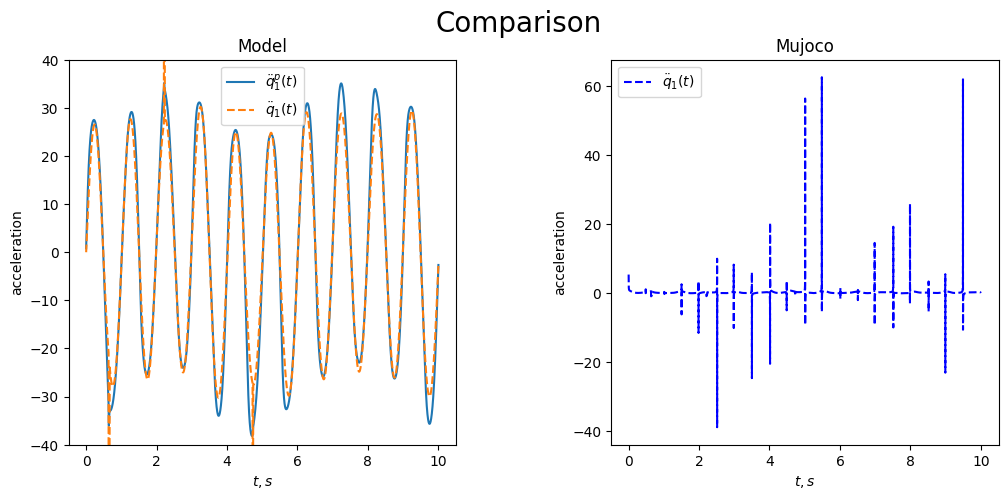

In [53]:
axes: list[plt.Axes]
figure: plt.Figure

figure, axes = plt.subplots(1, 2, figsize=(12, 5))
figure.suptitle("Comparison", fontsize=20)
figure.subplots_adjust(wspace=0.4, hspace=0.4)

axes[0].set_title("Model")
axes[0].plot(raw["time"], predicted_acc[:, 0], label="$\ddot{q}^p_1(t)$")
axes[0].plot(raw["time"], y_data[:, 0], "--", label="$\ddot{q}_1(t)$")
# axes[0].plot(raw['time'], predicted_acc[:, 1], color='r', label='$\ddot{q}^p_2(t)$')
axes[0].set_xlabel("$t, s$")
axes[0].set_ylim([-40, 40])
axes[0].set_ylabel("acceleration")
axes[0].legend()

axes[1].set_title("Mujoco")
axes[1].plot(raw["time"], (predicted_acc[:, 0] - y_data[:, 0]) / y_data[:, 0], "--", color="b", label="$\ddot{q}_1(t)$")
# axes[1].plot(raw['time'], y_data[:, 1], '--', color='r', label='$\ddot{q}_1(t)$')
# axes[1].set_ylim([-10, 10])
axes[1].set_xlabel("$t, s$")
axes[1].set_ylabel("acceleration")
axes[1].legend()

print(
    f"Total loss: {loss_fn(predicted_tensor, torch.tensor(y_data).to(device)).item():.3f}"
)